## Successful Vends

In [22]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from sklearn.metrics import r2_score
import warnings
from sklearn.externals import joblib 
warnings.filterwarnings('ignore')
%matplotlib inline 

In [23]:
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")

In [24]:
successfulVends = successfulVends_raw[["time","amount"]]

successfulVends.head()

,time,amount
0,2019-01-01 06:59:57,1
1,2019-01-02 07:40:31,300
2,2019-01-02 07:41:16,100
3,2019-01-02 07:41:12,900
4,2019-01-02 10:41:37,700


Normalization function

In [25]:
def normalize(z):
    x = z
    x = x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(np.vstack(x))
    joblib.dump(min_max_scaler, '/home/sylvia/pawa_project/anomaly_detection_app/services/anomaly_vends_scaler.pkl')
    x_scaled = min_max_scaler.transform(np.vstack(x))
    return x_scaled

Convert time to datetime

In [26]:
successfulVends['time']=pd.to_datetime(successfulVends.time)


Get amount after 10min

In [27]:
successfulVends_hour = successfulVends.resample('60min', on='time').sum()
successfulVends_hour.head()


,amount
time,
2019-01-01 06:00:00,1
2019-01-01 07:00:00,0
2019-01-01 08:00:00,0
2019-01-01 09:00:00,0
2019-01-01 10:00:00,0


Normalize the values

In [28]:
successfulVends_hour['amount']=normalize(successfulVends_hour['amount'])
successfulVends_hour.head()

,amount
time,
2019-01-01 06:00:00,0.000003
2019-01-01 07:00:00,0.000000
2019-01-01 08:00:00,0.000000
2019-01-01 09:00:00,0.000000
2019-01-01 10:00:00,0.000000


Get the train and test dataset
train: is the first 2 months
test: is the third month

In [29]:
train = successfulVends_hour[successfulVends_hour.index.month<3]
test = successfulVends_hour[successfulVends_hour.index.month==3]

### Classification Trees

Breakdown timestamp to other features so as to pass it to regressors i.e hour,day and day of the week

In [30]:
successfulVends_hour['hour'] = successfulVends_hour.index.hour
successfulVends_hour['week'] =  successfulVends_hour.index.week
successfulVends_hour['month'] =  successfulVends_hour.index.month
successfulVends_hour['day_of_week'] =  successfulVends_hour.index.dayofweek

successfulVends_hour=  successfulVends_hour.dropna()

successfulVends_hour.head()

,amount,hour,week,month,day_of_week
time,,,,,
2019-01-01 06:00:00,0.000003,6,1,1,1
2019-01-01 07:00:00,0.000000,7,1,1,1
2019-01-01 08:00:00,0.000000,8,1,1,1
2019-01-01 09:00:00,0.000000,9,1,1,1
2019-01-01 10:00:00,0.000000,10,1,1,1


Create a train and test dataset of the decomposed timestamp dataframe

In [31]:
train_decompose = successfulVends_hour[successfulVends_hour.index.month<3]
test_decompose = successfulVends_hour[successfulVends_hour.index.month==3]

Create train and test matrices without y column to pass to regression models

In [32]:
X_train = train_decompose.drop(columns=['amount']) 
X_test = test_decompose.drop(columns=['amount']) 

y_train = train_decompose.amount
y_test = test_decompose.amount

Import libraries for the model

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
 
#these are the hyperparameters that yielded the best test results (no grid search)
clf = RandomForestRegressor(max_depth=5, random_state=16,n_estimators=21)
clf.fit(X_train, y_train) 

y_ = clf.predict(X_test)
y_pred = clf.predict(X_train)

#get r_score
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.25125463134277026 			 0.16765143695539508


Creating dataframe to plot predictions and actual with ease

In [43]:
#using test
predictions= test
predictions['predictions'] = y_

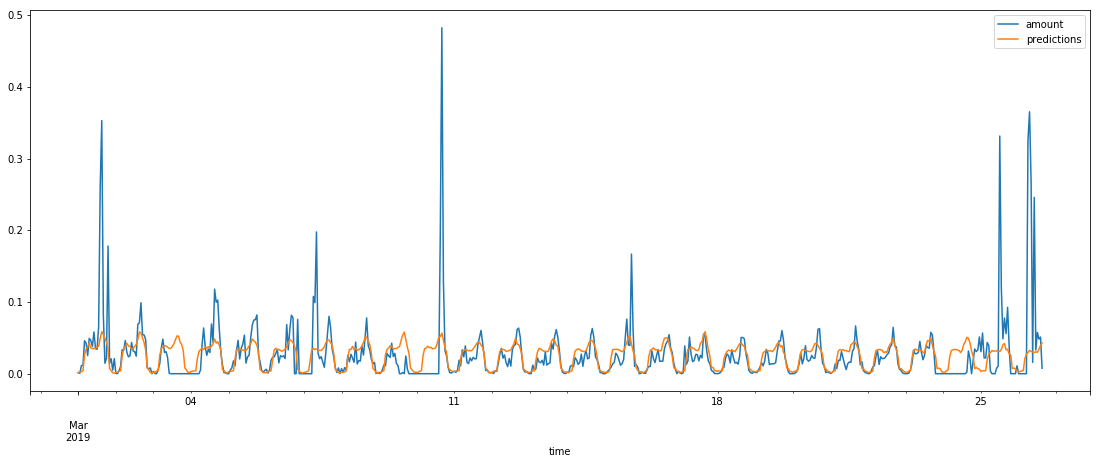

In [44]:
plt.rcParams['figure.figsize']=[19,7]
predictions.plot()

In [45]:
train.count()

amount    1410
dtype: int64

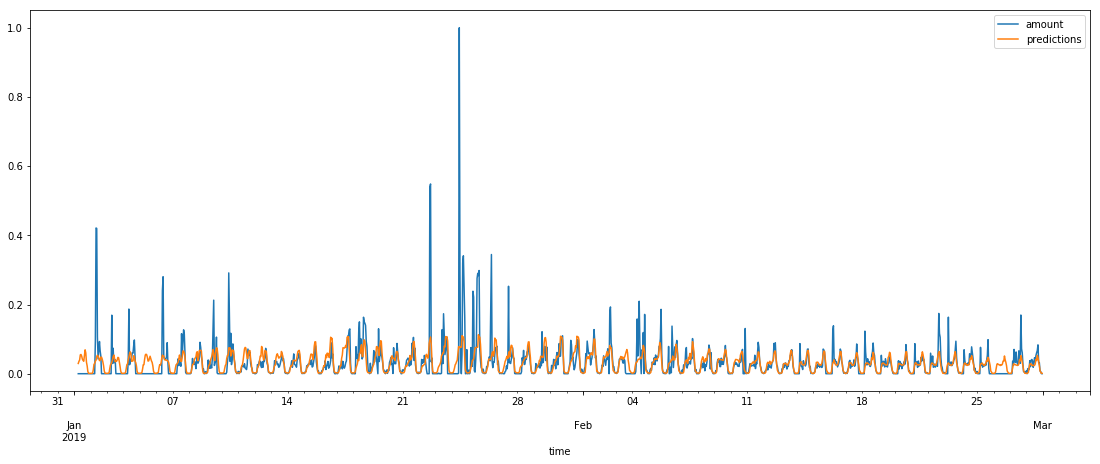

In [46]:
#using train
pred= train
pred['predictions'] = y_pred
pred.plot()

## KNN Regressor


In [38]:
from sklearn.neighbors import KNeighborsRegressor

#number of neighbours with best results (no grid search)
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train) 
    
y_ = neigh.predict(X_test)
y_pred = neigh.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.3872847510671267 			 0.13525194474549074


## Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

#no tuning of hyperparameters
reg = LinearRegression().fit(X_train, y_train)
y_ = reg.predict(X_test)
y_pred = reg.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.013886504087962215 			 -0.01673475083928677


## Stack Regressor

In [40]:
#Ensemble(stacking) for regressors (not sure how it works)
from mlxtend.regressor import StackingRegressor

#use the three algorithms

lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=3, random_state=16,n_estimators=25)

neigh = KNeighborsRegressor(n_neighbors=70)
stregr = StackingRegressor(regressors=[rfr, lr, neigh], 
                           meta_regressor=neigh)

# Training the stacking classifier

stregr.fit(X_train, y_train) 

y_ = stregr.predict(X_test)
y_pred = stregr.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))


0.26165573838578193 			 0.16345355903093994


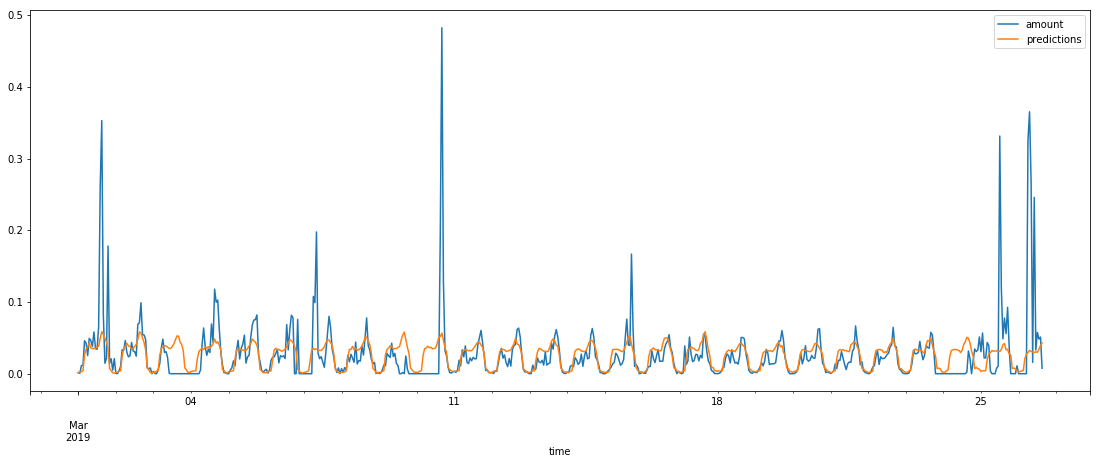

In [41]:
#using test
predictions= test
predictions['predictions'] = y_
predictions.plot()

In [42]:
joblib.dump(stregr, '/home/sylvia/pawa_project/anomaly_detection_app/services/project_vends_stackregressor.pkl')

['/home/sylvia/pawa_project/anomaly_detection_app/services/project_vends_stackregressor.pkl']